Final Paper Figure: Patient Data Analysis

Tricky: 0750910

Training: 0AC1713, 0AD1C10

In [101]:
import pandas as pd
import numpy as np
import h5py

In [102]:
from sklearn.neighbors import KDTree

def assign_labels(features1, features2, radius=2.0):
    """
    Assign labels to features1 from features2 where
    1) frame_id matches and
    2) distance between (x, y) <= radius.
    
    Returns an updated copy of features1 with a 'label' column.
    """
    # Ensure we have a 'label' column in features1, set default 0
    if 'label' not in features1.columns:
        features1['label'] = 0
    
    # Convert to avoid SettingWithCopyWarnings:
    features1 = features1.copy()
    features2 = features2.copy()
    
    # We will store subsets of features1 in a dictionary keyed by frame_id
    grouped_f1 = dict(tuple(features1.groupby('frame_id')))
    # Also group features2 by frame_id
    grouped_f2 = dict(tuple(features2.groupby('frame_id')))
    
    # For efficient column access:
    label_col_idx = features1.columns.get_loc('label')
    
    # We'll also store updated subsets in a dictionary
    updated_subsets = {}
    
    # Iterate only over frame_ids that are in features1
    for fid, subset_f1 in grouped_f1.items():
        # Build a KDTree for the (x, y) coords in features1 for this frame
        coords_f1 = subset_f1[['x', 'y']].values
        if len(coords_f1) > 0:
            kdtree = KDTree(coords_f1)
        else:
            updated_subsets[fid] = subset_f1
            continue
        
        # If this frame_id also exists in features2, we do the radius queries
        if fid in grouped_f2:
            subset_f2 = grouped_f2[fid]
            coords_f2 = subset_f2[['x', 'y']].values
            
            # Use query_radius to find neighbors within the given radius
            neighbor_indices_array = kdtree.query_radius(coords_f2, r=radius)
            
            # Convert subset_f1 to numpy for assignment, then we will put it back in a DataFrame
            subset_f1_values = subset_f1.values
            
            # Assign label for each set of neighbor indices
            for i, indices in enumerate(neighbor_indices_array):
                if len(indices) > 0:
                    lbl = subset_f2.iloc[i]['label']
                    subset_f1_values[indices, label_col_idx] = lbl
            
            # Re-wrap in a dataframe
            subset_f1_updated = pd.DataFrame(subset_f1_values, 
                                             columns=subset_f1.columns,
                                             index=subset_f1.index)
        else:
            # No labels to assign if there's no corresponding frame in features2
            subset_f1_updated = subset_f1
        
        updated_subsets[fid] = subset_f1_updated
    
    # Concatenate all updated subsets back together
    updated_features1 = pd.concat(updated_subsets.values(), axis=0)
    
    return updated_features1

In [103]:
slide_list = ["0AC1713", "0AD1C10", "0A8C907", "075846", "0AD7604", "0AA5304", "0AC4905", "0750910"]  # Replace with actual slide names
slide_list = ["0AC1713", "0AD1C10", "0A8C907", "075846", "0AD7604", "0AA5304", "0AC4905", "0750910"]  # Replace with actual slide names

annotated_path = '/mnt/deepstore/Final_DeepPhenotyping/figures/figure7_patient/top10k'
data_path = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/output/patients_0428'

results_list = []

for slide in slide_list:
    print(f"Processing slide: {slide}")
    
    # Load the features
    features1_path = f"{data_path}/{slide}/{slide}.parquet.gz"
    features2_path = f"{annotated_path}/{slide}_top10k.hdf5"
    
    features1 = pd.read_parquet(features1_path)
    
    features2 = pd.read_hdf(features2_path, key='features')

    #if features2 label is 0, set it to -1
    features2.loc[features2['label'] == 0, 'label'] = -1
    
    # Assign labels
    updated_features1 = assign_labels(features1, features2)

    #subset to those with DAPI_mean > 4000
    updated_features1 = updated_features1[updated_features1['DAPI_mean'] > 4000]

    updated_features1 = updated_features1.iloc[:,-129:]

    if slide=='0AC4905':
        #change label of 1 to 0
        updated_features1.loc[updated_features1['label'] == 1, 'label'] = 0

    #add to results list
    results_list.append(updated_features1)    

Processing slide: 0AC1713
Processing slide: 0AD1C10
Processing slide: 0A8C907
Processing slide: 075846
Processing slide: 0AD7604
Processing slide: 0AA5304
Processing slide: 0AC4905
Processing slide: 0750910


In [104]:
train_slides = results_list[:2]
train_slides = pd.concat(train_slides, axis=0)
train_slides = train_slides.reset_index(drop=True)


In [105]:
train_df = train_slides

In [106]:
train_df.columns

Index(['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9',
       ...
       'z119', 'z120', 'z121', 'z122', 'z123', 'z124', 'z125', 'z126', 'z127',
       'label'],
      dtype='object', length=129)

In [107]:
#set random seed for sampling
np.random.seed(42)

#remove rows with label 0
train_df = pd.concat([train_df[train_df['label'] == 0].sample(2500, random_state=42), train_df[train_df['label'] != 0]], ignore_index=True)

#randomly subsample 2500 rows with a label of -1 to better balance the dataset, keeping the rest of the data
train_df = pd.concat([train_df[train_df['label'] == -1].sample(2500, random_state=42), train_df[train_df['label'] != -1]], ignore_index=True)

#randomly subsample 2500 rows with a label of 0 to better balance the dataset, keeping the rest of the data
#train_df = pd.concat([train_df[train_df['label'] == 0].sample(2000, random_state=42), train_df[train_df['label'] != 0]], ignore_index=True)

#randomly subsample 500 rows with a label of 2 to better balance the dataset, keeping the rest of the data
#train_df = pd.concat([train_df[train_df['label'] == 2].sample(1000, random_state=42), train_df[train_df['label'] != 2]], ignore_index=True)

train_df['label'].value_counts()

 2.0    2734
-1.0    2500
 0.0    2500
 1.0     177
Name: label, dtype: int64

In [108]:
#change all labels of -1 to 0
train_df['label'] = train_df['label'].replace(-1, 0)


In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [110]:
#get X and y, where x is all but the last column and y is the last column
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

In [111]:
scaler = StandardScaler()   
X = scaler.fit_transform(X)

In [112]:
print(np.unique(y, return_counts=True))

(array([0., 1., 2.]), array([5000,  177, 2734]))


In [113]:
#class weights based on the number of samples in each class
class_counts = np.bincount(y.astype(int))
class_weights = {i: len(y) / (len(class_counts) * count) for i, count in enumerate(class_counts)}
class_weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32)
print(class_weights)

tensor([ 0.5274, 14.8983,  0.9645])


In [114]:
class TabDataset(Dataset):
    """Simple tabular dataset that stores tensors directly."""
    def __init__(self, X, y):
        self.X = torch.as_tensor(X, dtype=torch.float32)   # (N, 128)
        self.y = torch.as_tensor(y, dtype=torch.long)      # (N,)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Create a DataLoader for the training data
train_dataset = TabDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


In [115]:
class FCNet(nn.Module):
    def __init__(self, in_features=128, n_classes=3):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = FCNet(in_features = 128, n_classes=3)


In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# e.g. weight the positive class more heavily
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()  # No class weights

#criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ------------------------------------------------------------------
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:                     # rows shuffled every epoch
        xb, yb = xb.to(device), yb.to(device)  # move to GPU if available

        optimizer.zero_grad()
        logits = model(xb)            # forward pass
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f"Epoch {epoch:02d}/{num_epochs} | train‑loss: {running_loss:.4f}")


Using device: cuda
Epoch 01/50 | train‑loss: 0.9023
Epoch 02/50 | train‑loss: 0.5431
Epoch 03/50 | train‑loss: 0.3001
Epoch 04/50 | train‑loss: 0.1884
Epoch 05/50 | train‑loss: 0.1290
Epoch 06/50 | train‑loss: 0.0956
Epoch 07/50 | train‑loss: 0.0804
Epoch 08/50 | train‑loss: 0.0760
Epoch 09/50 | train‑loss: 0.0655
Epoch 10/50 | train‑loss: 0.0681
Epoch 11/50 | train‑loss: 0.0593
Epoch 12/50 | train‑loss: 0.0583
Epoch 13/50 | train‑loss: 0.0562
Epoch 14/50 | train‑loss: 0.0547
Epoch 15/50 | train‑loss: 0.0529
Epoch 16/50 | train‑loss: 0.0514
Epoch 17/50 | train‑loss: 0.0499
Epoch 18/50 | train‑loss: 0.0511
Epoch 19/50 | train‑loss: 0.0474
Epoch 20/50 | train‑loss: 0.0483
Epoch 21/50 | train‑loss: 0.0440
Epoch 22/50 | train‑loss: 0.0466
Epoch 23/50 | train‑loss: 0.0445
Epoch 24/50 | train‑loss: 0.0455
Epoch 25/50 | train‑loss: 0.0418
Epoch 26/50 | train‑loss: 0.0421
Epoch 27/50 | train‑loss: 0.0446
Epoch 28/50 | train‑loss: 0.0438
Epoch 29/50 | train‑loss: 0.0411
Epoch 30/50 | train‑loss

In [117]:
from sklearn.metrics import classification_report

def eval_model(model, slide_list, scaler, device):
    """
    Returns
    -------
    slide_results : dict
        { slide_id : { 'y_true': np.ndarray,       # (N,)
                       'y_pred': np.ndarray,       # (N,)
                       'y_prob': np.ndarray } }    # (N, n_classes)
    """
    model.eval()
    slide_results = {}

    for i, slide_df in enumerate(slide_list):
        
        X = slide_df.iloc[:, :-1].values
        y = slide_df.iloc[:, -1].values

        # if y is not in [0,1,2] set it to 0
        y = np.where(y > 2, 0, y)
        y = np.where(y < 0, 0, y)

        X=scaler.transform(X)

        ds      = TabDataset(X, y)
        loader  = DataLoader(ds, batch_size=100_000, shuffle=False)

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device, non_blocking=True)
                logits = model(xb)
                probs  = torch.softmax(logits, 1)

                y_true.extend(yb.cpu().numpy())
                y_pred.extend(torch.argmax(probs, 1).cpu().numpy())
                y_prob.extend(probs.cpu().numpy())   # (B, n_classes)

        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        y_prob = np.asarray(y_prob)

        print(f"\nSlide — classification report")
        print(classification_report(y_true, y_pred))

        # ---- keep the exact structure you had ----
        slide_results[i] = {
            "y_true": y_true,   # (N,)
            "y_pred": y_pred,   # (N,)
            "y_prob": y_prob    # (N, n_classes)
        }

    return slide_results


In [118]:
test_slides = results_list[2:]

results = eval_model(model, test_slides, scaler, device)


Slide — classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2451171
           1       0.82      0.74      0.78        19
           2       0.75      0.92      0.83        13

    accuracy                           1.00   2451203
   macro avg       0.86      0.89      0.87   2451203
weighted avg       1.00      1.00      1.00   2451203


Slide — classification report


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2268987
           1       0.95      0.66      0.78        29
           2       0.00      0.00      0.00         0

    accuracy                           1.00   2269016
   macro avg       0.65      0.55      0.59   2269016
weighted avg       1.00      1.00      1.00   2269016


Slide — classification report


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2172343
           1       0.96      0.88      0.92        26
           2       0.00      0.00      0.00         0

    accuracy                           1.00   2172369
   macro avg       0.65      0.63      0.64   2172369
weighted avg       1.00      1.00      1.00   2172369


Slide — classification report


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2258221
           1       0.94      0.73      0.82        22
           2       0.00      0.00      0.00         0

    accuracy                           1.00   2258243
   macro avg       0.65      0.58      0.61   2258243
weighted avg       1.00      1.00      1.00   2258243


Slide — classification report


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2516967
           1       0.00      0.00      0.00         0
           2       0.95      0.94      0.95      2000

    accuracy                           1.00   2518967
   macro avg       0.65      0.65      0.65   2518967
weighted avg       1.00      1.00      1.00   2518967


Slide — classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1858186
           1       0.97      0.81      0.88       663
           2       0.78      0.98      0.87       473

    accuracy                           1.00   1859322
   macro avg       0.92      0.93      0.92   1859322
weighted avg       1.00      1.00      1.00   1859322



In [119]:
#remove the last slide from the results
#results.popitem()

print(results.keys())

dict_keys([0, 1, 2, 3, 4, 5])


In [120]:
from sklearn.metrics import precision_score, recall_score

# 1) concatenate across all slides
all_y_true = np.concatenate([results[slide_id]['y_true'] for slide_id in results])
all_y_pred = np.concatenate([results[slide_id]['y_pred'] for slide_id in results])


# 2) determine the set of classes
class_labels = np.unique(all_y_true)

# 3) per‑class precision & recall
precision_per_class = precision_score(all_y_true, all_y_pred,
                                      labels=class_labels, average=None)
recall_per_class    = recall_score(   all_y_true, all_y_pred,
                                      labels=class_labels, average=None)

# 4) overall (micro) metrics
overall_precision = precision_score(all_y_true, all_y_pred, average='micro')
overall_recall    = recall_score(   all_y_true, all_y_pred, average='micro')

# 5) mean (macro) metrics
mean_precision = precision_score(all_y_true, all_y_pred, average='macro')
mean_recall    = recall_score(   all_y_true, all_y_pred, average='macro')

# 6) standard deviation across classes
std_precision = np.std(precision_per_class)
std_recall    = np.std(recall_per_class)

# 7) map to dictionaries
precision_dict = dict(zip(class_labels, precision_per_class))
recall_dict    = dict(zip(class_labels, recall_per_class))

summary = {
    'overall_precision': overall_precision,
    'overall_recall':    overall_recall,
    'mean_precision':    mean_precision,
    'mean_recall':       mean_recall,
    'precision_std':     std_precision,
    'recall_std':        std_recall
}

# 8) print results
print("Per‑class precision:", precision_dict)
print("Per‑class recall:   ", recall_dict)
print()
print("Summary metrics:", summary)

Per‑class precision: {0: 0.9999974123488626, 1: 0.8272108843537415, 2: 0.9040307101727447}
Per‑class recall:    {0: 0.9999903887918526, 1: 0.8010540184453228, 2: 0.9473049074818987}

Summary metrics: {'overall_precision': 0.999969547169365, 'overall_recall': 0.999969547169365, 'mean_precision': 0.9104130022917829, 'mean_recall': 0.9161164382396914, 'precision_std': 0.0706840213139752, 'recall_std': 0.08415644289820005}


In [233]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- Matplotlib style (same as first script) ----------
plt.rcParams.update(
{
    "font.family": "Arial",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 0.6,
    "figure.dpi": 300,
    }
)

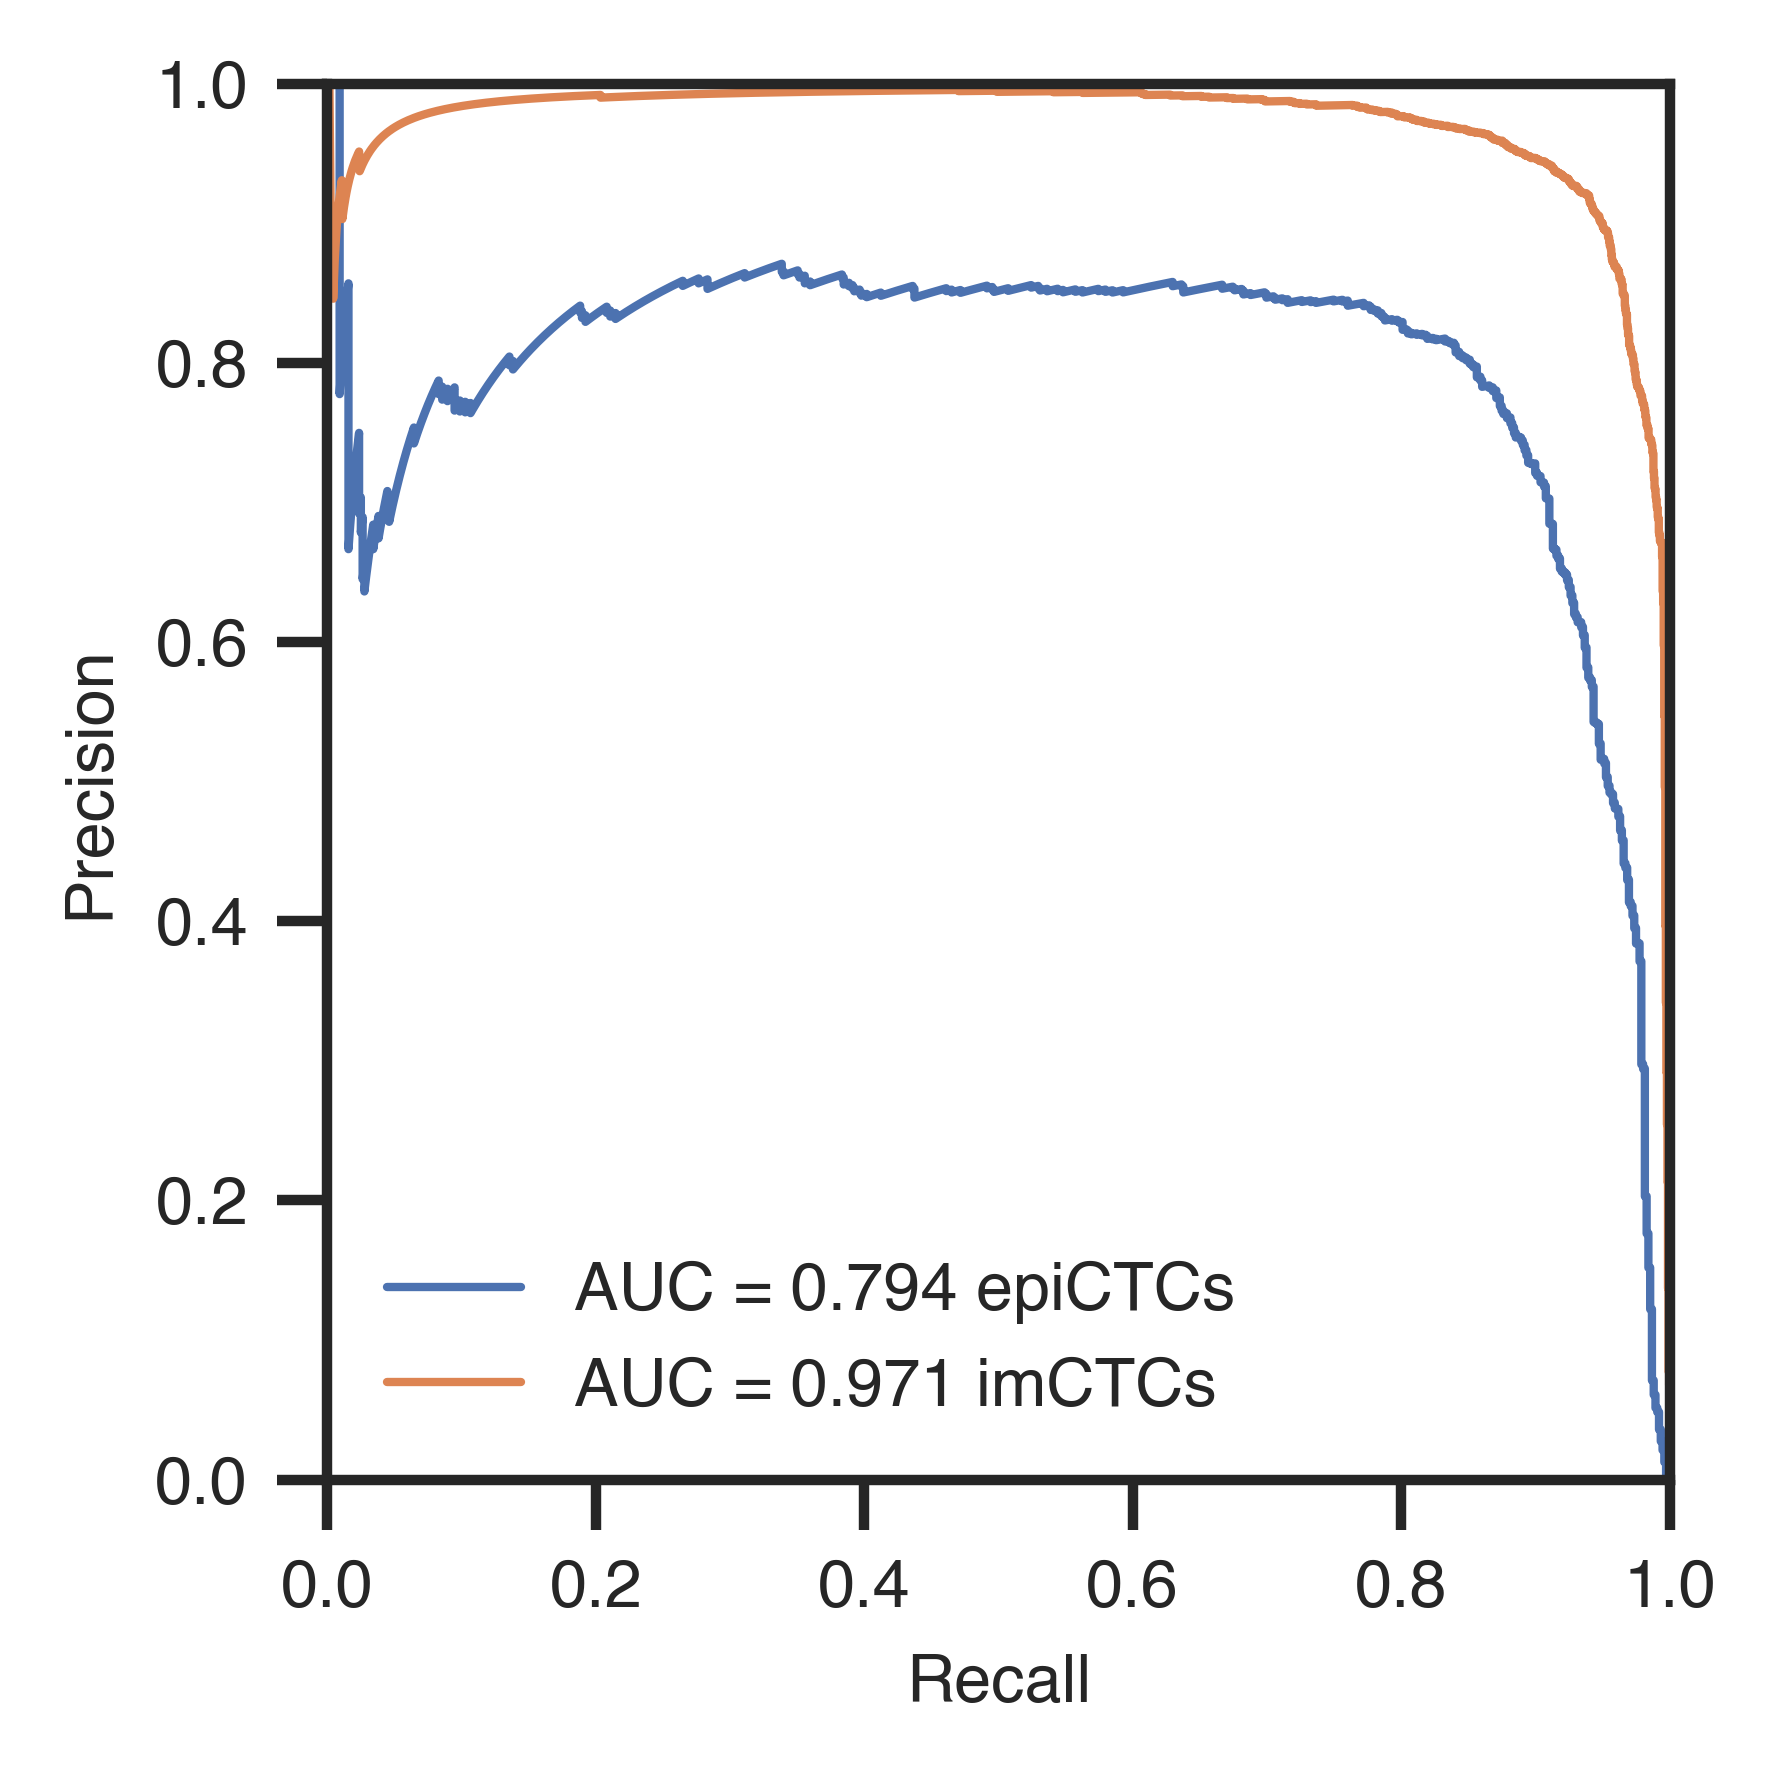

In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# ---------------------------------------------------
#  gather your data
# ---------------------------------------------------
y_true   = np.concatenate([results[s]['y_true'] for s in results])
y_scores = np.concatenate([results[s]['y_prob'] for s in results])   # shape (N, ?)

# label IDs in the order you want on the axes
class_labels = [0, 1, 2]          # 0=Others, 1=Epi‑CTC, 2=Imm‑like‑CTC
class_names  = {0: "Others",
                1: "epiCTCs",
                2: "imCTCs"}

# ---------------------------------------------------
#  make sure the score matrix has the same #cols as classes
# ---------------------------------------------------
if y_scores.shape[1] == len(class_labels) - 1:
    # assume cols are p(class 1), p(class 2)
    others_prob = 1.0 - y_scores.sum(axis=1, keepdims=True)
    y_scores    = np.hstack([others_prob, y_scores])   # cols: 0,1,2

# ---------------------------------------------------
#  binarize y_true for one‑vs‑rest PR curves
# ---------------------------------------------------
y_true_bin = label_binarize(y_true, classes=class_labels)

# ---------------------------------------------------
#  compute precision–recall curves
# ---------------------------------------------------
pr_curves = {}
for i, c in enumerate(class_labels):
    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    ap           = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    pr_curves[c] = {"precision": prec, "recall": rec, "ap": ap}


In [238]:
colors = ['red', 'grey']

class_names  = {0: "Others",
                1: "CTC",
                2: "imCTC"}


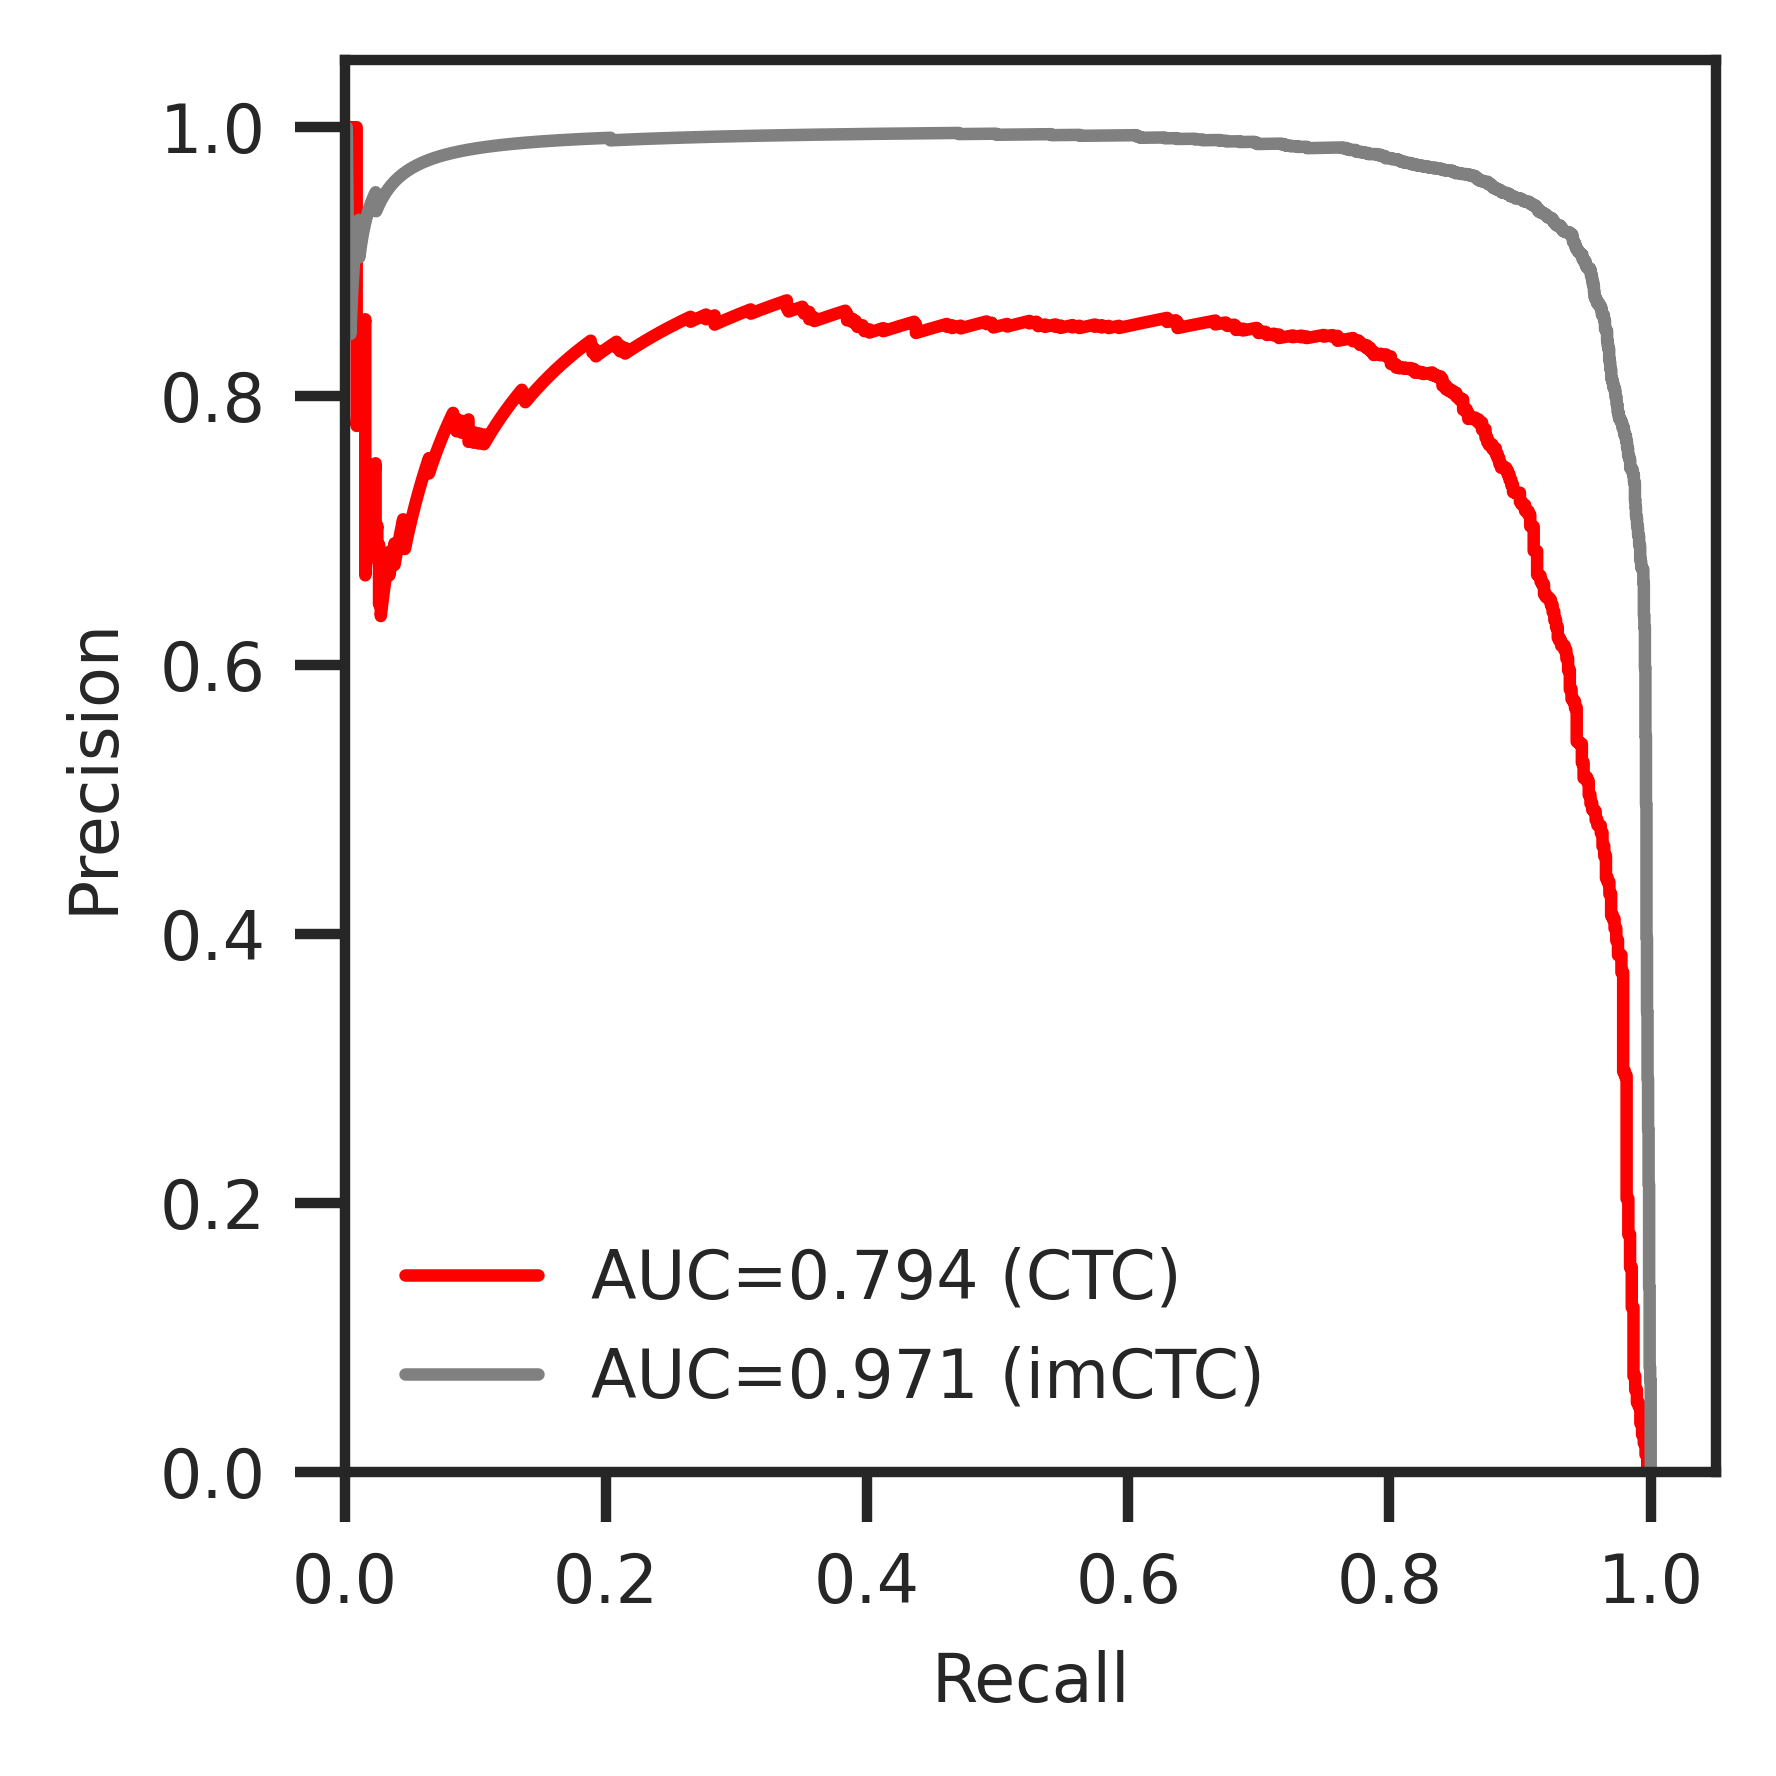

In [239]:
# ---------------------------------------------------
#  plot (skip the “Others” curve if you like)
# ---------------------------------------------------
plot_classes = [1, 2]          # omit 0 if you don’t care about it

plt.figure(figsize=(3, 3), dpi=600)
for c in plot_classes:
    p  = pr_curves[c]["precision"]
    r  = pr_curves[c]["recall"]
    ap = pr_curves[c]["ap"]
    plt.plot(r, p,
             label=f"AUC={ap:.3f} ({class_names[c]})", color=colors[c-1], lw=1.5)

plt.xlabel("Recall", fontsize=8)
plt.ylabel("Precision", fontsize=8)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=8)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=8)
plt.grid(False)
plt.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig("/mnt/deepstore/Final_DeepPhenotyping/figures/figure7_patient/pr_curve.pdf", dpi=600, bbox_inches='tight')
plt.show()

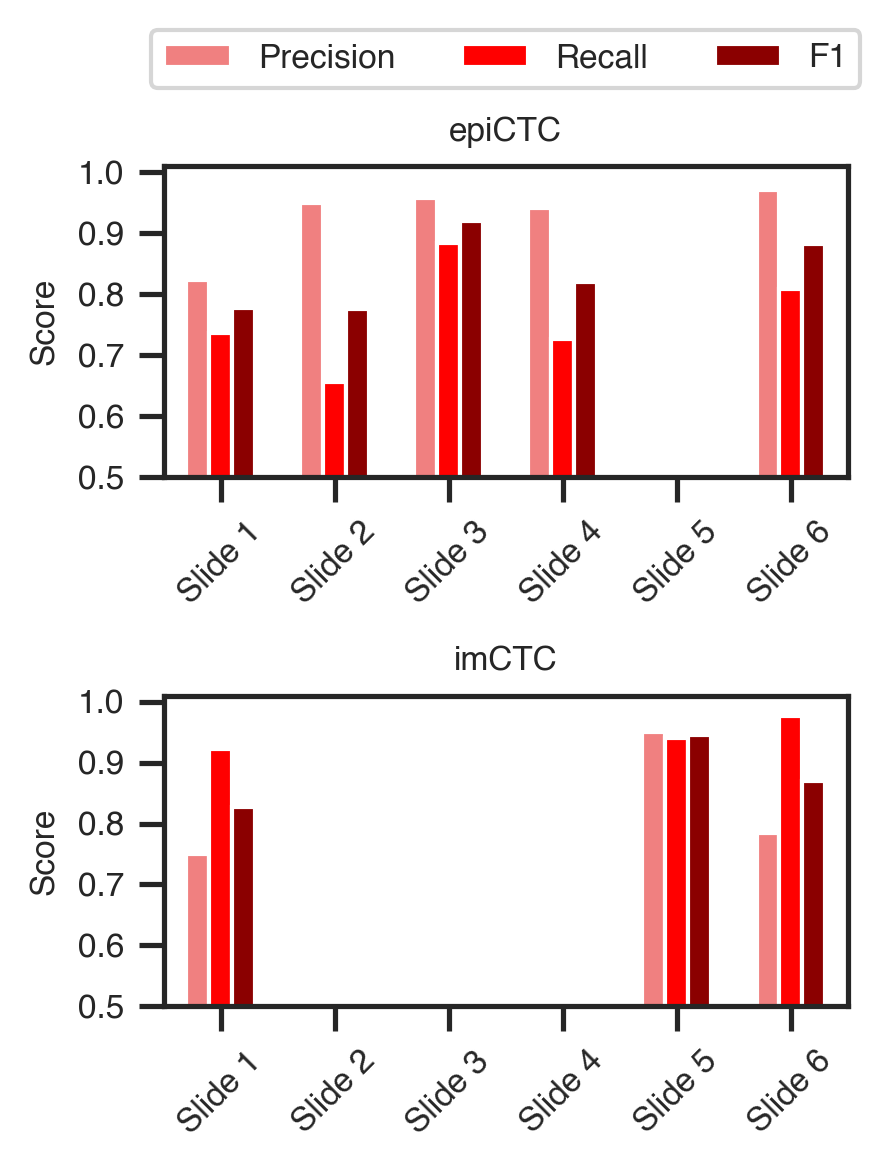

In [217]:
epi_metrics = {'Precision': [], 'Recall': [], 'F1': []}
im_metrics = {'Precision': [], 'Recall': [], 'F1': []}
epi_support = []
im_support = []

for res in results.values():
    y_true, y_pred = res['y_true'], res['y_pred']
    prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=class_labels, zero_division=0)

    epi_metrics['Precision'].append(prec[0])
    epi_metrics['Recall'].append(rec[0])
    epi_metrics['F1'].append(f1[0])
    epi_support.append(support[0])

    im_metrics['Precision'].append(prec[1])
    im_metrics['Recall'].append(rec[1])
    im_metrics['F1'].append(f1[1])
    im_support.append(support[1])

# -------- Plot (just like the original) --------
colors = {
    'Precision': 'lightcoral',
    'Recall': 'red',
    'F1': 'darkred'
}
bar_width = 0.2

plt.figure(figsize=(3, 4))
x = np.linspace(0, 5, num=6)

# SK-BR-3
plt.subplot(2, 1, 1)
plt.xlim(-0.5, 5.5)
plt.bar(x - bar_width, epi_metrics['Precision'], width=bar_width, color=colors['Precision'], label='Precision')
plt.bar(x,              epi_metrics['Recall'],    width=bar_width, color=colors['Recall'],    label='Recall')
plt.bar(x + bar_width,  epi_metrics['F1'],        width=bar_width, color=colors['F1'],        label='F1')

plt.xticks(x, slide_names, rotation=45, ha='center', fontsize=8)
plt.ylabel('Score', fontsize=8)
plt.title('epiCTC', fontsize=8)
plt.ylim(0.5, 1.01)
plt.yticks(np.arange(0.5, 1.001, 0.1), fontsize=8)
plt.legend(frameon=True, loc='lower center', fontsize=8, ncol=3, bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()

# HPAEC
plt.subplot(2, 1, 2)
plt.xlim(-0.5, 5.5)
plt.bar(x - bar_width, im_metrics['Precision'], width=bar_width, color=colors['Precision'], label='Precision')
plt.bar(x,              im_metrics['Recall'],    width=bar_width, color=colors['Recall'],    label='Recall')
plt.bar(x + bar_width,  im_metrics['F1'],        width=bar_width, color=colors['F1'],        label='F1')

plt.xticks(x, slide_names, rotation=45, ha='center', fontsize=8)
plt.title('imCTC', fontsize=8)
plt.ylim(0.5, 1.01)
plt.ylabel('Score', fontsize=8)
plt.yticks(np.arange(0.5, 1.001, 0.1), fontsize=8)
plt.tight_layout()

plt.savefig("/mnt/deepstore/Final_DeepPhenotyping/figures/figure7_patient/perpatientslide.pdf", dpi=600, bbox_inches=None)
plt.show()


In [219]:
#save the metrics data to a csv file, one for epiCTC and one for imCTC
import pandas as pd

epi_metrics_df = pd.DataFrame(
    {
        'Slide': slide_names,
        'Precision': epi_metrics['Precision'],
        'Recall': epi_metrics['Recall'],
        'F1': epi_metrics['F1'],
        'Support': epi_support
    }
)

epi_metrics_df.to_csv("/mnt/deepstore/Final_DeepPhenotyping/figures/figure7_patient/epiCTC_metrics.csv", index=False)
im_metrics_df = pd.DataFrame(
    {
        'Slide': slide_names,
        'Precision': im_metrics['Precision'],
        'Recall': im_metrics['Recall'],
        'F1': im_metrics['F1'],
        'Support': im_support
    }
)
im_metrics_df.to_csv("/mnt/deepstore/Final_DeepPhenotyping/figures/figure7_patient/imCTC_metrics.csv", index=False)

